In [18]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


# Styling for Seaborn Graphs
sns.set_theme(
    style="whitegrid",
    context="talk",        
    palette="Set2"         
)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titleweight"] = "bold"

# Filter out warnings from notebook
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")



In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### Although TotalCharges appears numeric in spreadsheet tools, pandas identifies it as an object due to the presence of blank string values (e.g. for new customers with zero tenure). This will require explicit cleaning and type conversion before modeling.

In [11]:
df["Churn"].value_counts()


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [12]:
df["Churn"].value_counts(normalize=True)


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [30]:
numeric_summary = (
    df.groupby("Churn")[["tenure", "MonthlyCharges"]]
      .mean()
      .T
      .rename(columns={"No": "mean_non_churn", "Yes": "mean_churn"})
)

numeric_summary["difference"] = (
    numeric_summary["mean_churn"] - numeric_summary["mean_non_churn"]
)

numeric_summary


Churn,mean_non_churn,mean_churn,difference
tenure,37.569965,17.979133,-19.590832
MonthlyCharges,61.265124,74.441332,13.176209


In [31]:
categorical_cols = df.select_dtypes(include="object").columns.drop(
    ["customerID", "Churn"]
)

churn_rates = []

for col in categorical_cols:
    rates = (
        df.groupby(col)["Churn"]
          .apply(lambda x: (x == "Yes").mean())
          .reset_index(name="churn_rate")
    )
    rates["feature"] = col
    churn_rates.append(rates)

churn_rates_df = pd.concat(churn_rates, ignore_index=True)
churn_rates_df


,gender,churn_rate,feature,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges
0,Female,0.269209,gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Male,0.261603,gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.329580,Partner,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.196649,Partner,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.312791,Dependents,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,NaN,0.000000,TotalCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997.75
6568,NaN,0.000000,TotalCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,998.1
6569,NaN,1.000000,TotalCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999.45
6570,NaN,0.000000,TotalCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999.8


In [32]:
feature_impact = (
    churn_rates_df
    .groupby("feature")["churn_rate"]
    .agg(["min", "max"])
)

feature_impact["range"] = feature_impact["max"] - feature_impact["min"]
feature_impact.sort_values("range", ascending=False)


,min,max,range
feature,,,
TotalCharges,0.000000,1.000000,1.000000
Contract,0.028319,0.427097,0.398778
InternetService,0.074050,0.418928,0.344878
OnlineSecurity,0.074050,0.417667,0.343617
TechSupport,0.074050,0.416355,0.342305
OnlineBackup,0.074050,0.399288,0.325238
DeviceProtection,0.074050,0.391276,0.317226
PaymentMethod,0.152431,0.452854,0.300423
StreamingMovies,0.074050,0.336804,0.262755


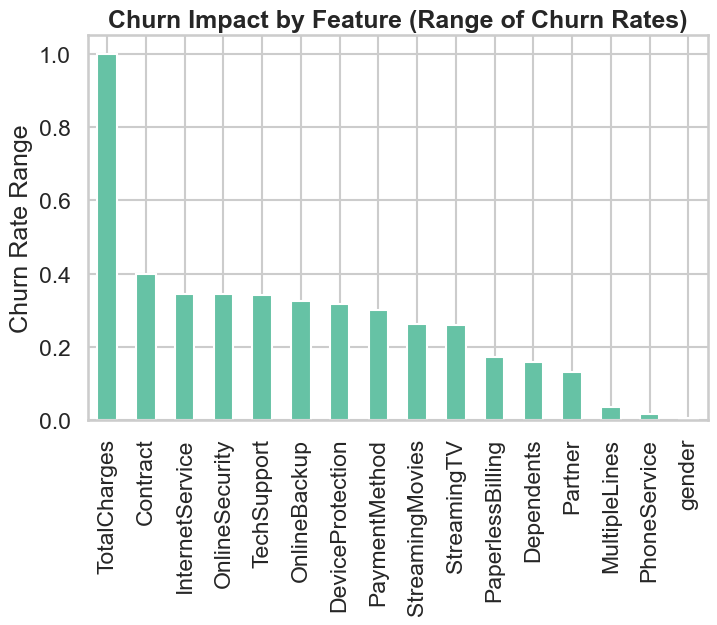

In [33]:
plt.figure(figsize=(8, 5))

feature_impact.sort_values("range", ascending=False)["range"].plot(kind="bar")

plt.title("Churn Impact by Feature (Range of Churn Rates)")
plt.ylabel("Churn Rate Range")
plt.xlabel("")
plt.show()


#### An initial univariate churn impact analysis identified tenure, contract type, and monthly charges as the strongest indicators of churn, based on the magnitude of differences in churn rates across customer segments.

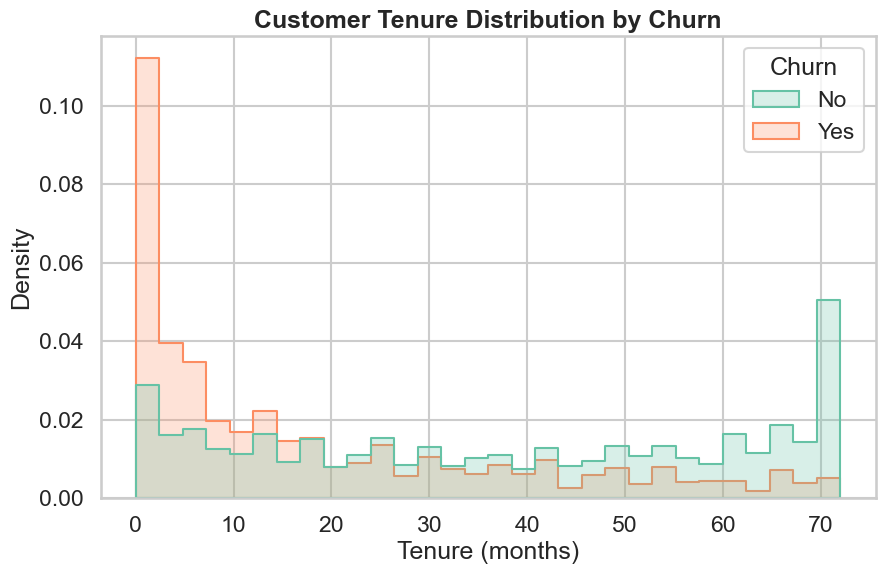

In [24]:
sns.histplot(
    data=df,
    x="tenure",
    hue="Churn",
    bins=30,
    element="step",   
    stat="density",
    common_norm=False
)

plt.title("Customer Tenure Distribution by Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Density")
plt.show()


### Tenure vs churn 
##### Customers who churn tend to do so early in their lifecycle, with a strong concentration at low tenure values. In contrast, customers who do not churn are distributed across much longer tenures, indicating that churn risk decreases substantially as customer tenure increases.

##

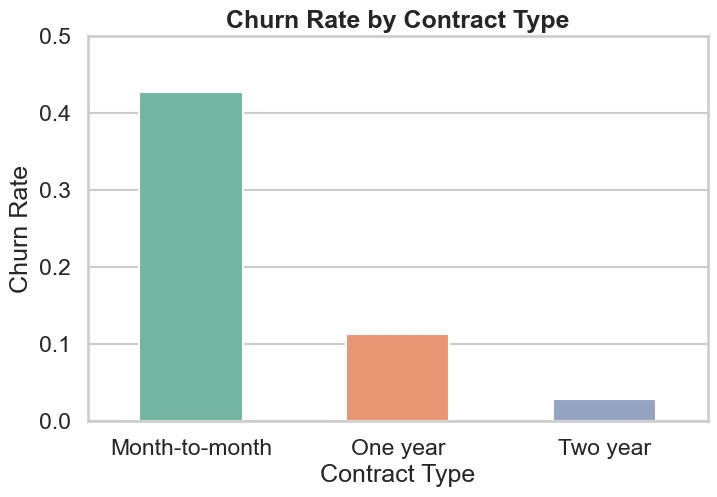

In [ ]:
plt.figure(figsize=(8, 5))  

sns.barplot(
    data=contract_churn,
    x="Contract",
    y="churn_rate",
    width=0.5               
)

plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Churn Rate")
plt.ylim(0, 0.5)            
plt.show()


### Contract Type and Churn

##### Customers on month-to-month contracts exhibit a significantly higher churn rate compared to those on longer-term contracts. One-year contracts reduce churn substantially, while two-year contracts have the lowest churn rates overall. This indicates that longer contract commitments are strongly associated with improved customer retention and lower churn risk.

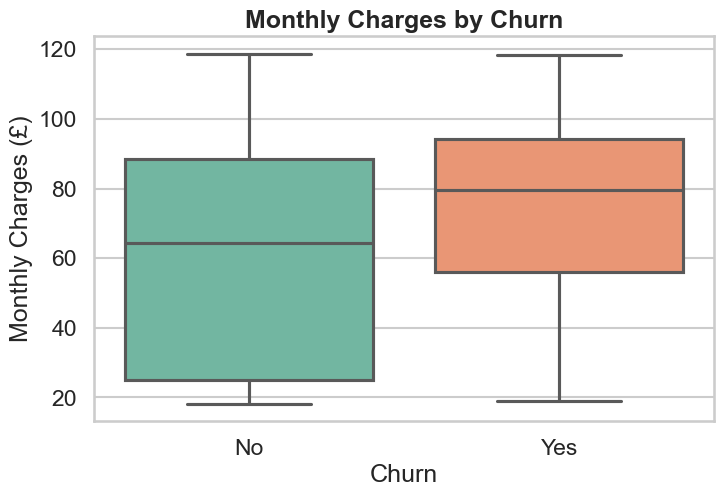

In [27]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df,
    x="Churn",
    y="MonthlyCharges"
)

plt.title("Monthly Charges by Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges (£)")
plt.show()


### Monthly Charges and Churn
##### Customers who churn tend to have higher average monthly charges than retained customers, indicating that pricing pressure or perceived value may contribute to churn risk.